<a href="https://colab.research.google.com/github/marcoshr/Seattle_Airbnb_Open_Data/blob/master/Seattle_Airbnb_Open_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seattle Airbnb Open Data - Data Science Project**

This notebook is part of the Data Science Nanodegree program at Udacity.

This notebook is meant to serve as a template for future data mining processes.

## **Preliminaries**

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive") #, force_remount=True)

!pwd
!which python
!python --version

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/usr/local/bin/python
Python 3.7.11


### Business Questions

Questions related to business or real-world applications of how the data could be used:
- How well is Airbnb collecting its data?
- Which variables in the dataset are highly related to each other?
- How well can we predict the price of homestays?

### Libraries

In [ ]:
import sys
import random
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error

from xgboost import XGBRegressor

## **Data Exploration**

### Dataset Description


Data extracted from https://www.kaggle.com/airbnb/seattle/data
  
Context

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.
  
Content

The following Airbnb activity is included in this Seattle dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day
  
Inspiration

- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

For more ideas, visualizations of all Seattle datasets can be found [here](http://insideairbnb.com/seattle/).
  
Acknowledgement

This dataset is part of Airbnb Inside, and the original source can be found [here](http://insideairbnb.com/get-the-data.html).

### Reading data

In [ ]:
# df_calendar = pd.read_csv('/content/drive/MyDrive/3. Nanodegree/Data/calendar.csv')
# df_reviews = pd.read_csv('/content/drive/MyDrive/3. Nanodegree/Data/reviews.csv')

df = pd.read_csv('/content/drive/MyDrive/7. Proyectos/Data Science/Nanodegree - Udacity/Data/listings.csv')

In [ ]:
# # df_calendar
# display(df_calendar.columns)
# display(df_calendar.shape)
# display(df_calendar.head())

In [ ]:
# # df_reviews
# display(df_reviews.columns)
# display(df_reviews.shape)
# display(df_reviews.head())

In [ ]:
df.shape

(3818, 92)

In [ ]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [ ]:
print(len(df.columns))
df.columns

92


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [ ]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

In [ ]:
# Before data preparation: Find which columns are numeric and which categorical
print("Number of columns: " + str(df.shape[1]), end="\n\n")

print("Numerical variables: " + str(len(df.dtypes[df.dtypes != "object"])))
# print(df.dtypes[df.dtypes != "object"])
num_df = df.select_dtypes(include=['int64', 'float64'])
print(num_df.shape, end="\n\n")
num_df_cols = num_df.columns

print("Categorical variables: " + str(len(df.dtypes[df.dtypes == "object"])))
#print(df.dtypes[df.dtypes == "object"])
cat_df = df.select_dtypes(include=['object'])
print(cat_df.shape, end="\n\n")
cat_df_cols = cat_df.columns

Number of columns: 92

Numerical variables: 30
(3818, 30)

Categorical variables: 62
(3818, 62)



## **Data Preparation**

In [ ]:
# Refactor spaces for underscores in feature names
df.columns = [label.replace(' ', '_') for label in df.columns]
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

### Missing values

In [ ]:
# Get the number of missing values for every column higher than cutoff
i = 1
cutoff = 0.5 # To see all use: 0
col_len = df.shape[0]

print("Columns with >= " + str(round(cutoff*100)) + "% values missing:", end="\n\n")


for col_name in df.columns:
    
    num_missing = sum(df[col_name].isna())
    perc_missing = num_missing/col_len

    if perc_missing >= cutoff:
      print(str(i) + ". " + col_name, end="  ")
      print(str(num_missing) + "/" + str(col_len) + "  (" + str(round(perc_missing*100)) + "%)")

    i += 1

Columns with >= 50% values missing:

57. square_feet  3721/3818  (97%)
60. monthly_price  2301/3818  (60%)
61. security_deposit  1952/3818  (51%)
85. license  3818/3818  (100%)


In [ ]:
# Drop columns with a single unique value including the missing values
# This includes dropping the columns with all missing values --> df = df.dropna(how="all", axis=1)
nunique = df.nunique(dropna=False)
cols_to_drop = nunique[nunique == 1].index

print("Columns to drop: " + str(len(cols_to_drop)))
print(cols_to_drop)

df = df.drop(cols_to_drop, axis=1)
df.shape

Columns to drop: 11
Index(['scrape_id', 'last_scraped', 'experiences_offered', 'market',
       'country_code', 'country', 'has_availability', 'calendar_last_scraped',
       'requires_license', 'license', 'jurisdiction_names'],
      dtype='object')


(3818, 81)

In [ ]:
# # Exploratory code to understand nunique() function

# # We want to remove only columns with one unique value including the missing values
# df_test = pd.DataFrame({'A': [1, 2, 3], 
#                         'B': [1, 1, 1],
#                         'C': [None, None, None], 
#                         'D': [1, 2, None],
#                         'E': [1, 1, None]})
# nunique = df_test.nunique(dropna=False)
# print(nunique)
# cols_to_drop = nunique[nunique == 1].index

# print("Columns to drop: " + str(len(cols_to_drop)))
# print(cols_to_drop)

# df_test = df_test.drop(cols_to_drop, axis=1)
# print(df_test.shape)
# df_test

In [ ]:
# Drop the rows with missing values in response column
response_col = "price"
df = df.dropna(subset=[response_col])
df.shape   

(3818, 81)

In [ ]:
# Tranform response variable to numeric (if neceessary)
df[response_col] = df[response_col].apply(lambda value: pd.to_numeric(value.replace("$", "").replace(",", "")))
print(df[response_col])

0        85.0
1       150.0
2       975.0
3       100.0
4       450.0
        ...  
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64


### Correlation matrix

Number of numerical variables: 29


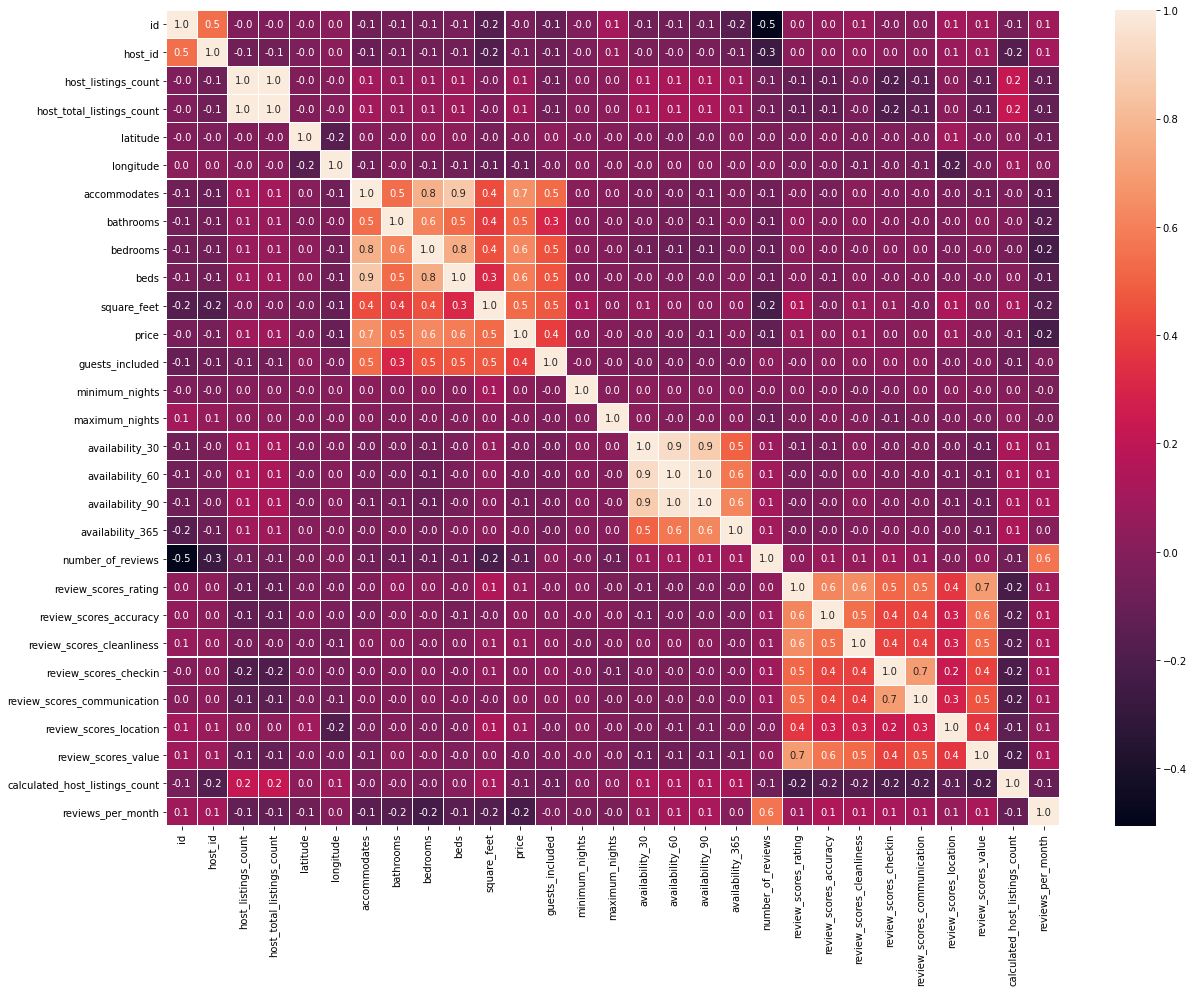

In [ ]:
# Which variables are related to another
# The heatmap only visualizes numerical features as they are the ones that can show correlation
print("Number of numerical variables: " + str(len(df.dtypes[df.dtypes != "object"])))
plt.figure(figsize = (20, 15)) # width, height. ratio 4:3
sns.heatmap(df.corr(), annot=True, linewidths=.1, fmt=".1f");

From the heatmap we observe the following correlations between features:
- High correlation (>= |+-0.8|)
 - host_total_listings_count <--> host_listings_count
 - bedrooms <--> accommodates <--> beds
 - availability_30 <--> availability_60 <--> availability_90

### Handling categorical data

In [ ]:
# Find which columns are numeric and which categorical
print("Number of columns: " + str(df.shape[1]), end="\n\n")

print("Numerical variables: " + str(len(df.dtypes[df.dtypes != "object"])))
# print(df.dtypes[df.dtypes != "object"])
num_df = df.select_dtypes(include=['int64', 'float64'])
print(num_df.shape, end="\n\n")
num_df_cols = num_df.columns

print("Categorical variables: " + str(len(df.dtypes[df.dtypes == "object"])))
#print(df.dtypes[df.dtypes == "object"])
cat_df = df.select_dtypes(include=['object'])
print(cat_df.shape, end="\n\n")
cat_df_cols = cat_df.columns

Number of columns: 81

Numerical variables: 29
(3818, 29)

Categorical variables: 52
(3818, 52)



In [ ]:
# Count unique and missing values in categorical columns with cutoff or less levels
cutoff = 30
i = 1
for col_name in cat_df.columns:
  col_value_counts = cat_df[col_name].value_counts(dropna=False)

  if len(col_value_counts) <= 20:
    print(str(i) + ". ----- " + col_name + " -----")
    print(col_value_counts, end="\n\n\n")
    i += 1

1. ----- host_response_time -----
within an hour        1692
within a few hours     968
within a day           597
NaN                    523
a few days or more      38
Name: host_response_time, dtype: int64


2. ----- host_acceptance_rate -----
100%    3044
NaN      773
0%         1
Name: host_acceptance_rate, dtype: int64


3. ----- host_is_superhost -----
f      3038
t       778
NaN       2
Name: host_is_superhost, dtype: int64


4. ----- host_has_profile_pic -----
t      3809
f         7
NaN       2
Name: host_has_profile_pic, dtype: int64


5. ----- host_identity_verified -----
t      2997
f       819
NaN       2
Name: host_identity_verified, dtype: int64


6. ----- neighbourhood_group_cleansed -----
Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade        

### Normality Test

"According to the central limit theorem, the distribution of the sample mean satisfies the normal distribution when the number of samples is larger than 30 [2]. Therefore, if the number of samples is larger than 30, the analysis can be performed on the assumption that the normality is satisfied."

J Rheum Dis. 2019 Jan;26(1):5-11. English.
Published online Dec 20, 2018.  https://doi.org/10.4078/jrd.2019.26.1.5
Copyright © 2019 by The Korean College of Rheumatology

### Splitting the data

In [ ]:
# Split data into X matrix and response vector y
X = df.loc[:, df.columns != response_col]
print(X.shape)

y = df[response_col]
print(y.shape)

(3818, 80)
(3818,)


In [ ]:
def create_dummy_df(df, cat_df_cols, dummy_na, show=True):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_df_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_df_cols
            3. dummy columns for each of the categorical columns in cat_df_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''

    if show: print("Original shape: " + str(df.shape))

    # For categorical columns only
    for col_name in df[cat_df_cols]:
        
        #print(col_name)

        # Get its dummies in a df
        df_with_dummies = pd.get_dummies(df[col_name], dummy_na=dummy_na, prefix=col_name, drop_first=True)
        
        # Attached df_with_dummies to original and store them at the end
        df = df.join(df_with_dummies, lsuffix=col_name)

        # Remove all the original columns in cat_df_cols
        del df[col_name]
    
    #print(df.columns)
    if show: print("Final shape: " + str(df.shape))
    
    return df

In [ ]:
# Override X with dummies for categorical variables
X = create_dummy_df(X, X.columns, dummy_na=True)

Original shape: (3818, 80)
Final shape: (3818, 76075)


In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
# Impute the mean of the column for any missing values in numerical columns
X_train = X_train.apply(lambda col: col.fillna(col.mean()))

## **Modelling**

In [ ]:
# Get together predictions from all models
y_pred_models = []

### Base Models

The following simple base models are included in order to compare relative metrics from more advanced models:
- Random Model
- Previous Value Model
- Mean Model

#### Random Model

In [ ]:
# Perform predictions with a random model whithin the range of the training data

# includes both limits
y_pred_rand_model = pd.Series(np.random.uniform(min(y_train), max(y_train), size=(len(y_test))))
len(y_pred_rand_model)

y_pred_models.append(y_pred_rand_model)

#### Previous Value Model

In [ ]:
# If time series, a model that always predicts the previous value (y_pred_prevv_model)
# y_pred_models.append(y_pred_prevv_model)

#### Mean/Mode Model

In [ ]:
# Predict always the mean of response training data

print("y_train mean:" +  str(np.mean(y_train)))
print("y_test length:" + str(len(y_test)), end="\n\n")

y_pred_mean_model = pd.Series([np.mean(y_train)]).repeat(len(y_test))

print(type(y_pred_mean_model), end="\n\n")
print(y_pred_mean_model)

y_pred_models.append(y_pred_mean_model)

y_train mean:127.2997754491018
y_test length:1146

<class 'pandas.core.series.Series'>

0    127.299775
0    127.299775
0    127.299775
0    127.299775
0    127.299775
        ...    
0    127.299775
0    127.299775
0    127.299775
0    127.299775
0    127.299775
Length: 1146, dtype: float64


### Linear Regression

In [ ]:
# Instantiate a LinearRegression model with normalized data
lm_model = LinearRegression(normalize=True)

In [ ]:
# Fit the model to the training data
lm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
# Predict the response for the test data
y_pred_lm_model = lm_model.predict(X_test)
y_pred_models.append(y_pred_lm_model)

### Random Forest

In [ ]:
# Instantiate the model
rf_model = RandomForestClassifier(random_state=42, verbose=1)

In [ ]:
# Fit the model to the training data
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [ ]:
# Predict the response for the test data
y_pred_rf_model = rf_model.predict(X_test)
y_pred_models.append(y_pred_rf_model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


### XGBoost

In [ ]:
# Instantiate the model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

In [ ]:
# Necessary cleaning for xgb model fitting and prediction
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
# Fit the model to the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# Predict the response for the test data
y_pred_xgb_model = xgb_model.predict(X_test)
y_pred_models.append(y_pred_xgb_model)

## **Evaluation**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Get results from model predictions (R-squared, RMSE and MAPE)

eval_metrics = {
    "R^2": [r2_score(y_test, y_pred) for y_pred in y_pred_models],
    "RMSE": [mean_squared_error(y_test, y_pred, squared=False) for y_pred in y_pred_models],
    "MAPE": [mean_absolute_percentage_error(y_test, y_pred) for y_pred in y_pred_models]
}

In [ ]:
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Metric', 'rand_model', 'mean_model', 'lm_model', 'rf_model', 'xgb_model'))

for k, v in eval_metrics.items():
  a, b, c, d, e = v
  print("{:<10} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format(k, a, b, c, d, e))

Metric     rand_model mean_model lm_model   rf_model   xgb_model 
R^2        -25.97     -0.00      0.33       0.41       0.57      
RMSE       480.57     92.57      75.63      71.30      60.50     
MAPE       409.37     49.76      43.94      27.59      30.29     


In [ ]:
# # Use a breakpoint if necessary
# sys.exit("Just a breakpoint!")

## **Visualization**

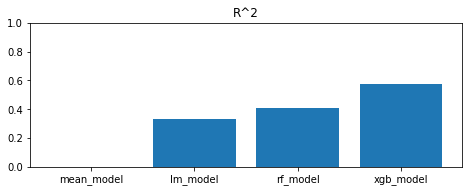

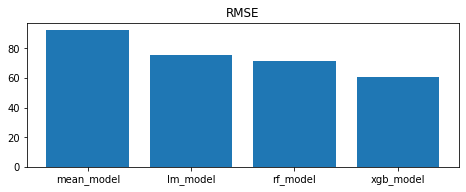

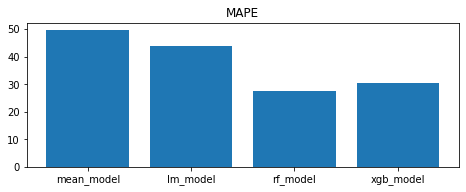

In [ ]:
# Plot evaluation metrics

models = ["rand_model", "mean_model", "lm_model", "rf_model", "xgb_model"]
metrics = ["R^2", "RMSE", "MAPE"]

i = 0
for metric in metrics:
  fig = plt.figure(figsize = (6, 2))
  axes = fig.add_axes([0,0,1,1])
  values = eval_metrics[metric][1:]
  axes.bar(models[1:], values)
  plt.title(metric)
  
  if metrics[i] == "R^2":
    axes.set_ylim([0,1])
  
  i+=1
  plt.show()

## **End**

### Possible Improvements

- Cross validation
- Outliers
- Standardization
- More relevant visualizations
- Check clean code and style check practices
- plot only the necessary half of the correlation matrix
- If its a time series, a model that always predicts the previous value (y_pred_prevv_model)
- Add option for classification problems in random model
- Modify column names changing spaces for underscores at the beginning of the process, not in the middle
- Automatize getting metrics in eval_metrics
- Automatize visualization depending on models and metrics used
- Show value in visualization
- Develop previous value model
- Write unit tests for DS using assert keyword and library pytest
- Check runtime of the whole code and blocks of code with time.time()
- Mean model for classification (mode)

---

[Github repository](https://github.com/marcoshr/Seattle_Airbnb_Open_Data.git)  
[Medium blog post](https://medium.com/@marcoshr/how-well-can-you-predict-prices-of-airbnb-houses-7ea54dc5140c)

---

2021  
Canary Islands, Spain  
[Marcos Hernández Rodríguez](https://www.linkedin.com/in/marcos-hern%C3%A1ndez-rodr%C3%ADguez/)

---